In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd '/content/drive/MyDrive/mini projet/'

/content/drive/MyDrive/mini projet


In [3]:
import numpy as np
from itertools import groupby
import pandas as pd
import os
from keras.layers import Conv2D, MaxPooling2D, Flatten, Conv1D, MaxPooling1D, Dropout, Dense
from scipy.io import loadmat
from matplotlib import pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from keras.utils import np_utils
from keras.callbacks import History
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from matplotlib.pyplot import imshow
from keras import Sequential
from keras.models import load_model
from keras.callbacks import History
from random import shuffle
from time import time


**Defining some functions**

In [4]:
def pad(img, h, w):

  result = np.zeros((h, w))
  result[:np.shape(img)[0], :np.shape(img)[1]] = img

  return result

In [5]:
def augmentation(signal):
  noise = np.random.normal(0,1,len(signal))

  signal_output = signal + noise
  signal_output = (signal_output - np.min(signal_output)) / (np.max(signal_output) - np.min(signal_output))
  
  return signal_output

In [6]:
def permute_cycles(signal):

  # get cycles
  cycles = detect_cycles(signal)
  cycles = np.array(cycles)

  # get indexies
  indexies = list(range(len(cycles)))

  # shuffle indexies
  shuffle(indexies)

  # shuffle cycles
  cycles_shuffled = cycles[indexies]

  # reconstruct signal
  signal_shuffled = np.concatenate(cycles_shuffled)

  # padding
  vector_out = np.zeros(len(signal))
  vector_out[:len(signal_shuffled)] = signal_shuffled
  
  return vector_out

In [7]:
def detect_cycles(vector_in):
  # split into zero/non zero
  vector_in = [list(g) for k, g in groupby(vector_in, key=lambda x:x!=0)]
  vector_in = np.array(vector_in)

  vector_out = []
  if all([v == 0 for v in vector_in[0]]):
    vector_work1 = vector_in[list(range(1, len(vector_in), 2))]
    vector_work2 = vector_in[list(range(2, len(vector_in), 2))]
  else:
    vector_work1 = vector_in[list(range(0, len(vector_in), 2))]
    vector_work2 = vector_in[list(range(1, len(vector_in), 2))]
    
  i = 0
  for element1, element2 in zip(vector_work1, vector_work2):
    i += 1
    vector_out.append(element1 + element2)

  #print('Found : {} cycles'.format(len(vector_out)))
  return vector_out

**Reading data**

In [8]:
raw_path = './Segmented GaitCycles (multidim)'
columns=['Time', 'LxVGRF1', 'LxVGRF2', 'LxVGRF3', 'LxVGRF4', 'LxVGRF5', 'LxVGRF6', 'LxVGRF7', 'LxVGRF8', 'RxVGRF1', 'RxVGRF2', 'RxVGRF3', 'RxVGRF4', 'RxVGRF5', 'RxVGRF6', 'RxVGRF7', 'RxVGRF8', 'Lx Total Force', 'Rx Total Force']
dfs = []

for element in os.listdir(raw_path)[:-3]:
  path = os.path.join(raw_path, element)

  # read .mat file
  mat = loadmat(path)  # load mat-fil
  dfs.append(pd.DataFrame(mat[element[:-4]], columns=columns))

dfs = np.array(dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [9]:
dfs[0]

,Time,LxVGRF1,LxVGRF2,LxVGRF3,LxVGRF4,LxVGRF5,LxVGRF6,LxVGRF7,LxVGRF8,RxVGRF1,RxVGRF2,RxVGRF3,RxVGRF4,RxVGRF5,RxVGRF6,RxVGRF7,RxVGRF8,Lx Total Force,Rx Total Force
0,5.8296,25.52,9.68,12.10,58.63,46.53,255.75,434.83,119.35,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,962.39,0.00
1,5.8396,23.21,7.70,9.68,51.70,42.35,257.95,439.67,123.53,3.41,0.00,0.00,5.61,0.0,0.0,0.0,0.0,955.79,9.02
2,5.8496,23.21,7.70,9.68,41.36,35.97,257.95,439.67,127.71,21.01,0.00,0.00,5.61,0.0,0.0,0.0,0.0,943.25,26.62
3,5.8596,20.90,7.70,7.26,32.67,29.59,255.75,437.25,129.80,49.17,0.00,7.15,5.61,0.0,0.0,0.0,0.0,920.92,61.93
4,5.8696,20.90,5.83,7.26,24.09,21.12,251.35,429.99,133.98,173.03,11.66,14.30,8.47,0.0,0.0,0.0,0.0,894.52,207.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7716,118.0417,23.21,11.66,12.10,136.18,73.26,246.95,300.41,78.65,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,882.42,0.00
7717,118.0517,20.90,7.70,9.68,127.27,70.95,251.35,309.54,80.74,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,878.13,0.00
7718,118.0617,18.59,5.83,7.26,118.25,68.64,255.75,318.56,84.81,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,877.69,0.00
7719,118.0717,16.17,5.83,4.84,107.14,66.33,260.15,325.27,86.79,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,872.52,0.00


In [10]:
np.shape(dfs)

(271,)

**Extra data**

In [11]:
# getting IDs if subjects
IDs = []
for element in os.listdir(raw_path)[:-3]:
  IDs.append(element[:6])

# reding file countaining Gender and Age
f = open("./demographics.txt", "r")
text = f.read().split('\n')

# getting Gender and Age
Data = {}
for element in text[1:]:
  vector_work = element.split('\t')
  Data[vector_work[0]] = [int(vector_work[4]), int(vector_work[5])]

# saving 'em
gen_age = []
for id in IDs:
  gen_age.append(Data[id])

gen_age = np.array(gen_age)

**Getting labes**

In [12]:
y = []
for element in os.listdir(raw_path)[:-3]:
  y.append(element[2:4])

# encoding
le = LabelEncoder()
le.fit(y)

y = le.transform(y)

In [13]:
vector_work = []
for df in dfs:
  for key in columns:
    vector_work.append(len(df[key].values[::3]))

length_max = np.max(vector_work)
print(length_max)

5978


**Separate DataBases**

In [14]:
database = []
for element in os.listdir(raw_path)[:-3]:
  database.append(element[0:2])
database = np.array(database)

dfs = dfs[database=='Ga']
y = y[database=='Ga']
gen_age = gen_age[database=='Ga']

In [15]:
np.shape(y)

(86,)

**Split data**

**1. When KFold**

In [16]:
train_indexies = [([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85]), ([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85]), ([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85]), ([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85]), ([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85]), ([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85]), ([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85]), ([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75])]

test_indexies = [([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), ([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]), ([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]), ([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]), ([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]), ([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]), ([66, 67, 68, 69, 70, 71, 72, 73, 74, 75]), ([76, 77, 78, 79, 80, 81, 82, 83, 84, 85])]

kf = KFold(n_splits=8)

#train_indexies = []
#test_indexies = []

#for train_index, test_index in kf.split(dfs):
#  train_indexies.append(train_index)
#  test_indexies.append(test_index)

i = 0
dfs_train, dfs_test, y_train, y_test, gen_age_train, gen_age_test = dfs[train_indexies[i]], dfs[test_indexies[i]], y[train_indexies[i]], y[test_indexies[i]], gen_age[train_indexies[i]], gen_age[test_indexies[i]] 

dfs_train, dfs_test, y_train, y_test, gen_age_train, gen_age_test = train_test_split(dfs, y, gen_age, test_size=0.5, shuffle= True)

**2. Whithout KFold**

In [17]:
dfs_train, dfs_test, y_train, y_test, gen_age_train, gen_age_test = train_test_split(dfs, y, gen_age, test_size=0.5, shuffle= True)

In [18]:
np.shape(dfs_test)

(43,)

**Preprocessing**

In [19]:
columns = ['LxVGRF1', 'LxVGRF2', 'LxVGRF3', 'LxVGRF4', 'LxVGRF5',
           'LxVGRF6', 'LxVGRF7', 'LxVGRF8', 'RxVGRF1', 'RxVGRF2', 'RxVGRF3',
           'RxVGRF4', 'RxVGRF5', 'RxVGRF6', 'RxVGRF7', 'RxVGRF8']

In [20]:
seuil = 0
signals = []
for df in dfs_train:
  signals_userX = []
  for key in columns:

    # getting signals
    vector_work = df[key].values

    # sampling
    signals_userX.append(vector_work[::3])

    # data augmentation
    for i in range(10):
      signals_userX.append(permute_cycles(vector_work[::3]))
      signals_userX.append(augmentation(vector_work[::3]))

  signals.append(signals_userX)

images_augmented = []
for signal in signals:
  if signal:
    vector_work = pad(signal, np.shape(signals)[1], length_max)
    images_augmented.append(vector_work)

images_augmented = np.array(images_augmented)
X_train = np.reshape(images_augmented, (images_augmented.shape[0]*21, int(images_augmented.shape[1]/21), images_augmented.shape[2], 1))
X_train = X_train/np.max(X_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

In [21]:
np.shape(X_train)

(903, 16, 5978, 1)

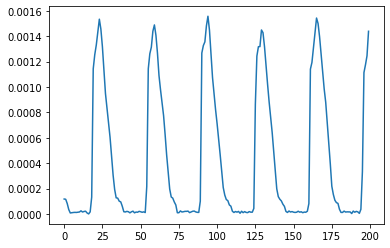

In [22]:
plt.plot(X_train[0, 10, :200])

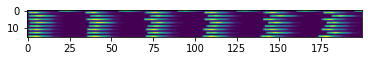

In [23]:
plt.imshow(X_train[0, :, :200, 0])

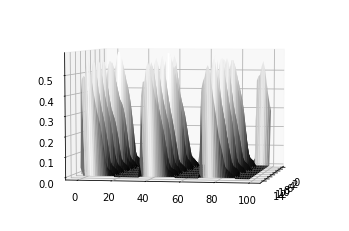

In [24]:
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:X_train[0, :, :100, 0].shape[0], 0:X_train[0, :, :100, 0].shape[1]]

# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, X_train[0, :, :100, 0] ,rstride=1, cstride=1, cmap=plt.cm.gray,
        linewidth=0)

ax.view_init(5, 10)

# show it
plt.show()



In [25]:
y_train_ = []
for element in y_train:
  for i in range(21):
     y_train_.append(element)
  
y_train = np.array(y_train_)

gen_age_train_ = []
for element in gen_age_train:
  for i in range(21):
     gen_age_train_.append(element)
  
gen_age_train = np.array(gen_age_train_)

In [26]:
np.shape(X_train)

(903, 16, 5978, 1)

**Data is ready**

**Training 1**

**Unbalanced database**

In [27]:
indexies_class_2 = np.where(y_train==0)[0]
indexies_class_1 = np.where(y_train==1)[0]
indexies_class_1 = indexies_class_1[:len(indexies_class_2)]
indexies = [elem for element in [indexies_class_2, indexies_class_1]
             for elem in element]
indexies = np.array(indexies)

X_train = X_train[indexies]
y_train = y_train[indexies]
gen_age_train = gen_age_train[indexies]

In [28]:
len(indexies_class_2)

420

In [29]:
np.shape(X_train)

(840, 16, 5978, 1)

**Test**

In [30]:
seuil = 0
signals = []
for df in dfs_test:
  signals_userX = []
  for key in columns:

    # getting signals
    vector_work = df[key].values

    # sampling
    signals_userX.append(vector_work[::3])

  signals.append(signals_userX)

images = []
for signal in signals:
  if signal:
    images.append(pad(signal, np.shape(signals)[1], length_max))

images = np.array(images)
images = np.reshape(images, np.shape(images) + (1,))
X_test = images/np.max(images)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [31]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

# building the network
model = Sequential()

# declaring the layers (conv + maxpoling)
# extraction des features
model.add(Input(shape=(16, length_max, 1)))

model.add(Conv2D(32, kernel_size=(16, 7), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(4, 4), padding="same"))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
BatchNormalization(),
model.add(Dropout(0.7))

model.add(Dense(1, activation='sigmoid'))

# loss function, metrics and optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 5978, 32)      3616      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 2989, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 2989, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 1495, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 1495, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 374, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 47872)             0

In [32]:
#model.load_weights('./weights.h5')

In [33]:
length_max

5978

In [34]:
np.shape(X_train)

(840, 16, 5978, 1)

In [35]:
start = time()
history = History()
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1, batch_size=32, callbacks=[history])

print(time()-start)

Epoch 1/30
27/27 [==============================] - 38s 146ms/step - loss: 0.6843 - accuracy: 0.6532 - val_loss: 0.6476 - val_accuracy: 0.9070
Epoch 2/30
27/27 [==============================] - 3s 102ms/step - loss: 0.6396 - accuracy: 0.8960 - val_loss: 0.6031 - val_accuracy: 0.9070
Epoch 3/30
27/27 [==============================] - 3s 101ms/step - loss: 0.5801 - accuracy: 0.9308 - val_loss: 0.5530 - val_accuracy: 0.9070
Epoch 4/30
27/27 [==============================] - 3s 102ms/step - loss: 0.5062 - accuracy: 0.9278 - val_loss: 0.4695 - val_accuracy: 0.9070
Epoch 5/30
27/27 [==============================] - 3s 101ms/step - loss: 0.4131 - accuracy: 0.9235 - val_loss: 0.4370 - val_accuracy: 0.8837
Epoch 6/30
27/27 [==============================] - 3s 103ms/step - loss: 0.3160 - accuracy: 0.9357 - val_loss: 0.3900 - val_accuracy: 0.9070
Epoch 7/30
27/27 [==============================] - 3s 102ms/step - loss: 0.2506 - accuracy: 0.9487 - val_loss: 0.3898 - val_accuracy: 0.8605
Epoch

In [36]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 17ms/step - loss: 0.6628 - accuracy: 0.8372


[0.6628383994102478, 0.8372092843055725]

In [37]:
print('Mean:', np.mean([90.91, 81.82, 100, 81.82, 90.91, 90.91, 90, 90]))
print('STD:', np.std([90.91, 81.82, 100, 81.82, 90.91, 90.91, 90, 90]))

Mean: 89.54624999999999
STD: 5.415971606046326


In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


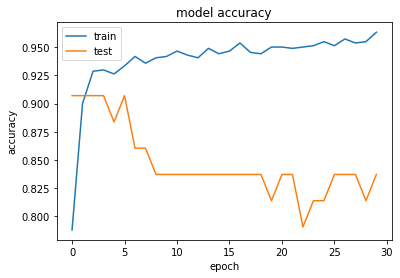

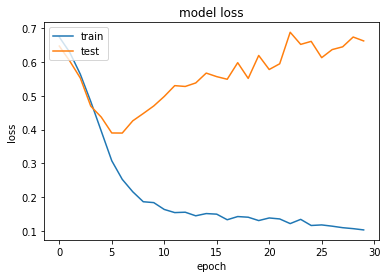

In [39]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
STOP HERE

SyntaxError: ignored

In [ ]:
#model.save_weights('./weights.h5')
#model.load_weights('./weights.h5')

**Feature extraction (using another classiffier but ANN)**

In [41]:
# building the network
model2 = Sequential()

# declaring the layers (conv + maxpoling)
# extraction des features
model2.add(Input(shape=(16, length_max, 1)))

model2.add(Conv2D(32, kernel_size=(16, 7), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(4, 4), padding="same"))

model2.add(Flatten())

In [43]:
for i in range(len(model.layers[0:6])):
  weights = model.layers[i].get_weights()
  model2.layers[i].set_weights(weights)
  

In [44]:
features_train = model2.predict(X_train)
features_test = model2.predict(X_test)

In [45]:
np.shape(features_train)

(840, 47872)

In [ ]:
pca = PCA(n_components=0.99)
pca.fit(features_train)

#pca.explained_variance_ratio_

X_train = pca.transform(features_train)
X_test = pca.transform(features_test)

In [46]:
features_train_new = np.concatenate((features_train, gen_age_train), axis=1)
features_test_new = np.concatenate((features_test, gen_age_test), axis=1)

In [ ]:
np.shape(features_train_new)

In [57]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(features_train_new, y_train)

#Predict the response for test dataset
y_pred = clf.predict(features_test_new)

print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='macro')
precision

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        12
           1       1.00      0.84      0.91        31

    accuracy                           0.88        43
   macro avg       0.85      0.92      0.87        43
weighted avg       0.92      0.88      0.89        43



0.8529411764705883

In [ ]:
np.shape(y_train)

In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
model = GaussianNB()

# Train the model using the training sets
model.fit(features_train_new, y_train)

y_pred = model.predict(features_test_new)

print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='macro')
precision

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        12
           1       1.00      0.61      0.76        31

    accuracy                           0.72        43
   macro avg       0.75      0.81      0.71        43
weighted avg       0.86      0.72      0.73        43



0.75

In [ ]:
np.shape(y_test)

In [59]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)

classifier.fit(features_train_new, y_train)

y_pred = classifier.predict(features_test_new)
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='macro')
precision

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.87      0.93        31

    accuracy                           0.91        43
   macro avg       0.88      0.94      0.89        43
weighted avg       0.93      0.91      0.91        43



0.875

In [53]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(features_train_new, y_train)
y_pred = clf.predict(features_test_new)


precision = precision_score(y_test, y_pred, average='weighted')
precision

0.9302325581395349

In [ ]:
np.shape(gen_age)

**ANN**

In [54]:
np.shape(features_train_new)

(840, 47874)

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

# define the keras model
model = Sequential()
model.add(Dense(32, input_dim=47874, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

In [56]:
model.fit(features_train_new, y_train, epochs=1000, validation_data=(features_test_new, y_test))

Epoch 1/1000
27/27 [==============================] - 1s 11ms/step - loss: 0.5149 - accuracy: 0.7547 - val_loss: 0.3552 - val_accuracy: 0.9070
Epoch 2/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.2783 - accuracy: 0.9184 - val_loss: 0.4632 - val_accuracy: 0.8372
Epoch 3/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.2357 - accuracy: 0.9105 - val_loss: 0.4968 - val_accuracy: 0.8372
Epoch 4/1000
27/27 [==============================] - 0s 7ms/step - loss: 0.2357 - accuracy: 0.9153 - val_loss: 0.4074 - val_accuracy: 0.8837
Epoch 5/1000
27/27 [==============================] - 0s 7ms/step - loss: 0.1913 - accuracy: 0.9208 - val_loss: 0.5421 - val_accuracy: 0.8372
Epoch 6/1000
27/27 [==============================] - 0s 7ms/step - loss: 0.1959 - accuracy: 0.9268 - val_loss: 0.4392 - val_accuracy: 0.8605
Epoch 7/1000
27/27 [==============================] - 0s 7ms/step - loss: 0.2004 - accuracy: 0.9146 - val_loss: 0.4371 - val_accuracy: 0.8837
Epoch

_NotOkStatusException: ignored

**Another model**

In [ ]:
# Input layer
input = tf.keras.layers.Input(shape=(None, None, 1))

# A convolution block
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same')(input)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2, padding='same')(x)

# A convolution block
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2, padding='same')(x)

# A convolution block
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2, padding='same')(x)

# Fully connected layer 1
x = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1)(x)
x = tf.keras.layers.Activation('relu')(x)

# Fully connected layer 2
x = tf.keras.layers.Conv2D(filters=5, kernel_size=1, strides=1)(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
predictions = tf.keras.layers.Activation('softmax')(x)

model = tf.keras.Model(inputs=input, outputs=predictions)

# loss function, metrics and optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
model.load_weights('./FCN.h5')

In [ ]:
# Input layer
input = tf.keras.layers.Input(shape=(None, None, 1))

# A convolution block
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same')(input)
x = tf.keras.layers.Activation(tf.keras.layers.LeakyReLU())(x)
x = tf.keras.layers.MaxPool2D(pool_size=2, padding='same')(x)

# A convolution block
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation(tf.keras.layers.LeakyReLU())(x)
x = tf.keras.layers.MaxPool2D(pool_size=2, padding='same')(x)

# A convolution block
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation(tf.keras.layers.LeakyReLU())(x)
x = tf.keras.layers.MaxPool2D(pool_size=2, padding='same')(x)

# Fully connected layer 1
x = tf.keras.layers.Conv2D(filters=50, kernel_size=1, strides=1)(x)
x = tf.keras.layers.Activation(tf.keras.layers.LeakyReLU())(x)

# Fully connected layer 2
x = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1)(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
predictions = tf.keras.layers.Activation('sigmoid')(x)

model2 = tf.keras.Model(inputs=input, outputs=predictions)

# loss function, metrics and optimizer
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
for i in range(len(model.layers)):
  print(model.layers[i])

In [ ]:
for i in range(len(model.layers[0:10])):
  weights = model.layers[i].get_weights()
  model2.layers[i].set_weights(weights)
  #model2.layers[i].trainable = False

In [ ]:
model2.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), verbose=1, batch_size=32)

**CNN 1D**

In [ ]:
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2], X_test.shape[3])

y_train = np.tile(y_train,16)
y_test = np.tile(y_test,16)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import regularizers

# building the network

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(length_max, 1)))
model.add(MaxPooling1D(pool_size=2, padding='same'))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))

model.add(Flatten())

model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))



#model.compile(optimizer='adam',  loss='binary_crossentropy',  metrics=['accuracy']) 
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001),  loss='binary_crossentropy',  metrics=['accuracy']) 

In [ ]:
model.fit(X_train, y_train, epochs=50 ,validation_split=0.3, batch_size=64 ,verbose=1)

In [ ]:
score = model.evaluate(X_test , y_test)

print( "%s:%.2f%%"%(model.metrics_names[0], score[0]*100))
print( "%s:%.2f%%"%(model.metrics_names[1], score[1]*100))